In [ ]:
import sys
!{sys.executable} -m pip install pathlib
!{sys.executable} -m pip install open3d

In [2]:
from scipy.spatial.transform import Rotation
import time

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

## Регистрация облаков точек

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def remove_floor_and_ceil(cloud, floor_height=-0.9, ceil_height=1.5):
    heights = np.linspace(-4.0, 4.0, 41)
    floor_index = None
    if floor_height == 'auto':
        bins = []
        for i, height in enumerate(heights[:-1]):
            bins.append(len(cloud[(cloud[:, 2] > height) * (cloud[:, 2] < heights[i + 1])]))
        #print('Bins:', bins)
        floor_index = np.argmax(bins[:20]) + 1
        floor_height = heights[floor_index]
        assert floor_index < len(heights) - 5
    if ceil_height == 'auto':
        if floor_index is None:
            floor_index = 0
            while floor_index < len(heights) - 6 and heights[floor_index] < floor_height:
                floor_index += 1
        ceil_index = floor_index + 5 + np.argmax(bins[floor_index + 5:])
        ceil_height = heights[ceil_index]
    #print('Floor height:', floor_height)
    #print('Ceil height:', ceil_height)
    return cloud[(cloud[:, 2] > floor_height) * (cloud[:, 2] < ceil_height)]

In [6]:
def raycast(grid, n_rays=1000, center_point=None):
    grid_raycasted = grid.copy()
    if center_point is None:
        center_point = (grid.shape[0] // 2, grid.shape[1] // 2)
    resolution = 0.1
    radius = 8.0 / resolution
    for sector in range(n_rays):
        angle = sector / n_rays * 2 * np.pi - np.pi
        ii = center_point[0] + np.sin(angle) * np.arange(0, radius)
        jj = center_point[1] + np.cos(angle) * np.arange(0, radius)
        ii = ii.astype(int)
        jj = jj.astype(int)
        good_ids = ((ii > 0) * (ii < grid.shape[0]) ** (jj > 0) * (jj < grid.shape[1])).astype(bool)
        ii = ii[good_ids]
        jj = jj[good_ids]
        points_on_ray = grid[ii, jj]
        if len(points_on_ray.nonzero()[0]) > 0:
            last_obst = points_on_ray.nonzero()[0][-1]
            grid_raycasted[ii[:last_obst], jj[:last_obst]] = 1
        #else:
            #grid_raycasted[ii, jj] = 1
    return grid_raycasted

In [7]:
def transform_grid(grid, ox, oy, theta):
    grid_transformed = np.full(grid.shape, 0)
    for x in range(len(grid[1])):
        for y in range(len(grid[0])):
            if (grid[y][x] != 0):
                newx = x - ox
                newy = y - oy
                newx = newx * np.cos(theta) + newy * np.sin(theta)
                newy = -newx * np.sin(theta) + newy * np.cos(theta)
                newx = int(np.rint(newx))
                newy = int(np.rint(newy))
                if newx < len(grid[1]) and newx>=0 and newy < len(grid[0]) and newy >= 0:
                    grid_transformed[newy][newx] = grid[y][x]
    return grid_transformed


def transform_pcd(cloud, x, y, theta):
    pcd_transformed = cloud.copy()
    for cldpoint in pcd_transformed:
        cldpoint[0] -= x
        cldpoint[1] -= y
        cldpoint[0] = cldpoint[0] * np.cos(theta) + cldpoint[1] * np.sin(theta)
        cldpoint[1] = -cldpoint[0] * np.sin(theta) + cldpoint[1] * np.cos(theta)


    return pcd_transformed

In [23]:
def get_occupancy_grid(points_xyz, resolution=0.1, radius=18, clip=8):
    index = np.isnan(points_xyz).any(axis=1)
    points_xyz = np.delete(points_xyz, index, axis=0)
    points_xyz = points_xyz[(points_xyz[:, 0] > -clip) * (points_xyz[:, 0] < clip) * \
                            (points_xyz[:, 1] > -clip) * (points_xyz[:, 1] < clip)]
    points_xyz_obstacles = remove_floor_and_ceil(points_xyz, floor_height=-0.3, ceil_height=0.5)
    #print('Points xyz:', points_xyz.shape, points_xyz[0], points_xyz.min(), points_xyz.max())
    grid = np.zeros((int(2 * radius / resolution), int(2 * radius / resolution)), dtype=np.uint8)
    points_ij = np.round(points_xyz[:, :2] / resolution).astype(int) + \
                        [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    grid[points_ij[:, 0], points_ij[:, 1]] = 1
    grid = raycast(grid)
    points_ij = np.round(points_xyz_obstacles[:, :2] / resolution).astype(int) + \
                [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    grid[points_ij[:, 0], points_ij[:, 1]] = 2
    return grid

In [8]:
def get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid, save=False, cnt=0):
    rel_x_rotated = -rel_x * np.cos(rel_theta) - rel_y * np.sin(rel_theta)
    rel_y_rotated = rel_x * np.sin(rel_theta) - rel_y * np.cos(rel_theta)
    rel_x, rel_y = rel_x_rotated, rel_y_rotated
    cur_grid_transformed = transform_grid(cur_grid, rel_x, rel_y, rel_theta)
    cur_grid_transformed[cur_grid_transformed > 0] = 1
    v_grid_copy = v_grid.copy()
    v_grid_copy[v_grid_copy > 0] = 1
    intersection = np.sum(v_grid_copy * cur_grid_transformed)
    union = np.sum(v_grid_copy | cur_grid_transformed)
    grid_aligned = np.zeros((v_grid.shape[0], v_grid.shape[1], 3))
    grid_aligned[:, :, 0] = cur_grid_transformed
    grid_aligned[:, :, 1] = v_grid
    grid_aligned = (grid_aligned * 255).astype(np.uint8)
    return intersection / union

In [9]:
def get_iou(rel_x, rel_y, rel_theta, cur_cloud, v_cloud):
    cur_grid = get_occupancy_grid(cur_cloud)
    v_grid = get_occupancy_grid(v_cloud)
    try:
        return get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid)
    except:
        return 0

In [10]:
def transform_icp(ref_cloud, cand_cloud, initial_transform):
    reg_p2p = o3d.pipelines.registration.registration_icp(cand_cloud, ref_cloud, 0.4, initial_transform, o3d.pipelines.registration.TransformationEstimationPointToPoint(), o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=100))
    transform_icp = reg_p2p.transformation # Your code here
    score_icp = reg_p2p.fitness
    return transform_icp, score_icp

In [11]:
def normalize(angle):
    while angle > np.pi:
        angle -= 2 * np.pi
    while angle < -np.pi:
        angle += 2 * np.pi
    return angle

def transformation_error(gt_pose_shift, tf_matrix_estimated):
    tf_rotation = Rotation.from_matrix(tf_matrix_estimated[:3, :3]).as_rotvec()
    gt_x, gt_y, gt_angle = gt_pose_shift
    #gt_angle = -gt_angle
    estimated_angle = tf_rotation[2]
    estimated_x = tf_matrix_estimated[0, 3]
    estimated_y = tf_matrix_estimated[1, 3]
    return (np.abs(estimated_x - gt_x), np.abs(estimated_y - gt_y), np.abs(normalize(estimated_angle - gt_angle)))

In [21]:
def get_rel_pose(x1, y1, theta1, x2, y2, theta2):
    orx = x2 - x1
    ory = y2 - y1
    orx = orx * np.cos(theta2 - theta1) + ory * np.sin(theta2 - theta1)
    ory = -orx * np.sin(theta2 - theta1) + ory * np.cos(theta2 - theta1)
    return [orx, ory, theta2 - theta1]

In [12]:
def preprocess_point_cloud(pcd, voxel_size):
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [13]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

In [ ]:
import open3d as o3d
def get_height_proj(pcd):
    points = np.asarray(pcd.points)
    points = remove_floor_and_ceil(points)
    highest_z = np.max(points[:, 2])
    projection_matrix = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 0]
    ])
    projected_points = points @ projection_matrix.T
    projected_point_cloud = o3d.geometry.PointCloud()
    projected_point_cloud.points = o3d.utility.Vector3dVector(projected_points)
    return projected_point_cloud



import numpy as np
from collections import defaultdict

def get_height_proj1(pcd):
    points = np.asarray(pcd.points)
    points = remove_floor_and_ceil(points)
    max_z_dict = defaultdict(lambda: {'z': -float('inf'), 'point': None})
    for point in points:
        x, y, z = point
        key = (round(x, 3), round(y, 3)) 
        
        if z > max_z_dict[key]['z']:
            max_z_dict[key]['z'] = z
            max_z_dict[key]['point'] = point
    projected_points = np.array([info['point'] for info in max_z_dict.values()])

    projected_point_cloud = o3d.geometry.PointCloud()
    projected_point_cloud.points = o3d.utility.Vector3dVector(projected_points)
    
    return projected_point_cloud



def save_point_cloud_to_txt(point_cloud, file_path):
    points = np.asarray(point_cloud.points)
    with open(file_path, 'a') as file:
        file.write(f"{len(points)}\n")
        for point in points:
            file.write(f"{point[0]} {point[1]} {point[2]}\n")

In [ ]:
import open3d as o3d
import numpy as np
import cv2
from PIL import Image

def generate_bv_image(point_cloud, resolution=0.2):
    downsampled_cloud = point_cloud.voxel_down_sample(voxel_size=resolution)

    points = np.asarray(downsampled_cloud.points)
    points = remove_floor_and_ceil(points)
    
    x_min, y_min = np.min(points[:, 0]), np.min(points[:, 1])
    x_max, y_max = np.max(points[:, 0]), np.max(points[:, 1])
    
    y_min_ind = int(y_min / resolution)
    y_max_ind = int(y_max / resolution)
    x_min_ind = int(x_min / resolution)
    x_max_ind = int(x_max / resolution)
    
    x_num = x_max_ind - x_min_ind + 1
    y_num = y_max_ind - y_min_ind + 1
    
    bv_image = np.zeros((y_num, x_num), dtype=np.uint8)
    
    for point in points:
        x, y = point[0], point[1]
        y_ind = y_max_ind - int(y / resolution)
        x_ind = x_max_ind - int(x / resolution)
        if 0 <= x_ind < x_num and 0 <= y_ind < y_num:
            bv_image[y_ind, x_ind] += 1
    

    max_pixel = np.max(bv_image)
    

    for y in range(y_num):
        for x in range(x_num):
            if bv_image[y, x] * 10 > 100:
                bv_image[y, x] = 100
            else:
                bv_image[y, x] = bv_image[y, x] * 10
            if bv_image[y, x] == 0:
                bv_image[y, x] = 10
    # cv2.startWindowThread()
    # cv2.imshow("Bird's Eye View", bv_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return bv_image, x_max_ind, y_max_ind

In [ ]:
def reconstruct_point_cloud_from_bv(bv_image, x_max_ind, y_max_ind, resolution=0.2):

    y_num, x_num = bv_image.shape
    

    points = []
    
    for y_ind in range(y_num):
        for x_ind in range(x_num):
            pixel_value = bv_image[y_ind, x_ind]
            
            if pixel_value <= 40:
                continue
            num_points = 1
            x_coord = (x_max_ind - x_ind) * resolution
            y_coord = (y_max_ind - y_ind) * resolution
        
            for _ in range(num_points):
                offset_x = 0 
                offset_y = 0 
                
                points.append([x_coord + offset_x, y_coord + offset_y, 0.0])
    
    point_cloud = o3d.geometry.PointCloud()
    if points: 
        point_cloud.points = o3d.utility.Vector3dVector(np.array(points))
    
    return point_cloud

In [17]:
import matplotlib.pyplot as plt
def plot_proj(pcl1):
    points = np.asarray(get_height_proj(pcl1).points)
    plt.figure(figsize=(8, 5))
    plt.scatter(points[:,0], points[:,1])
    plt.show()
    

In [18]:
def getMat(file):
    tm = np.eye(4)
    s = file.readline().split()
    if (s[0] == "*"):
        return tm
    s1 = file.readline().split()
    s2 = file.readline().split()
    dx = float(s[2])
    dy = float(s1[2])
    tm[:3, :3] = np.array([
            [float(s[0]), 0, float(s[1])],
            [0, 1, 0],
            [float(s1[0]), 0, float(s1[1])]
        ])
    tm[0][3] = dx
    tm[1][3] = dy
    if True in np.isnan(tm):
        return np.eye(4)
    return tm

In [19]:
import copy
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [ ]:
import open3d as o3d
import sys
import open3d.pipelines as o3dp


voxel_size = 0.1

test_results = []
ious = []
dists = []
icp_results = []
bv_result = []
h_result = []
icp_times = []

dataset_dir = 'test_mssplace_by_odometry_8'
pr_data_dir = os.path.join(dataset_dir, 'place_recognition_data')
graph_data_dir = os.path.join(dataset_dir, 'graph_data')

filename = "databv40.txt"

with open("result1.txt") as file, open("resultbv.txt") as file1:
    for ii, test_name in tqdm(list(enumerate(os.listdir(pr_data_dir)))):
        test_dir = os.path.join(pr_data_dir, test_name)
        try:
            transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
        except Exception as e:
            continue
        if transforms_.size == 0:
            continue
        if transforms_.ndim == 1:
            transforms_ = transforms_[np.newaxis, :]
        cand_clouds = {}
        cand_poses = {}
        # Reference cloud (from robot)
        ref_cloud = np.load(os.path.join(test_dir, 'cloud.npz'))['arr_0']
        ref_cloud = ref_cloud[:, :3]
        ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))
        if transforms_.size == 0:
            continue
        for idx in transforms_[:, 0]:
            cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
            pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
            cand_clouds[int(idx)] = cloud
            cand_poses[int(idx)] = pose_stamped[1:]
        gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))
        transforms = {}
        pr_scores = np.loadtxt(os.path.join(test_dir, 'pr_scores.txt'))
        ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

        target = o3d.geometry.PointCloud()
        target.points = o3d.utility.Vector3dVector(ref_cloud)



        # save_point_cloud_to_txt(newpc, filename)

        # with open(filename, 'a') as file:
        #     # Write the number of points as the first line
        #     file.write(f"{transforms_.size // 7} !\n")

        target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)

        for i in range(transforms_.size // 7):
            idx = transforms_[i, 0]
            pr_score = pr_scores[i]
            transforms[idx] = transforms_[i, 1:]
            gt_pose = cand_poses[int(idx)]
            pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)
            dist = np.sqrt(pose_shift[0] ** 2 + pose_shift[1] ** 2)
            dists.append(dist)
            # Candidate cloud (from graph of locations)
            cloud = cand_clouds[idx][:, :3]
            cloud = cloud[cloud == cloud].reshape((-1, 3))
            iou = get_iou(*pose_shift,ref_cloud, cloud)
            ious.append(iou)
            tm = getMat(file)
            tmbv = getMat(file1)
            
            
            source = o3d.geometry.PointCloud()
            source.points = o3d.utility.Vector3dVector(cloud)


            evaluationh = o3dp.registration.evaluate_registration(source, target,
                                                        0.4, tm)
            evaluationdm = o3dp.registration.evaluate_registration(source, target,
                                                        0.4, tmbv)

            
            # img, mx, my = generate_bv_image(source)
            # newpc = reconstruct_point_cloud_from_bv(img, mx, my)
            # save_point_cloud_to_txt(newpc, filename)
    
            # save_point_cloud_to_txt(get_height_proj(source), "data.txt")




            source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)

            # ICP
            # start_time = time.time()
            result_ransac = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)
            initial_transform = result_ransac.transformation
            tf_matrix_icp, fitness_icp = transform_icp(target, source, initial_transform)
            # icp_times.append(time.time() - start_time)
            icp_times.append(0.1)
            error_bv = transformation_error(pose_shift, np.linalg.inv(tmbv))
            error_h = transformation_error(pose_shift, np.linalg.inv(tm))
            error_icp = transformation_error(pose_shift, np.linalg.inv(tf_matrix_icp))
            icp_results.append((fitness_icp, error_icp))
            bv_result.append((evaluationdm.fitness, error_bv))
            h_result.append((evaluationh.fitness, error_h))

### Test set properties

In [ ]:
print('Total number of pairs:', len(ious))
print('Number of pairs with IoU > 0.5:', sum([i > 0.5 for i in ious]))
print('Number of pairs with IoU > 0.25:', sum([i > 0.25 for i in ious]))
print('Number of pairs closer than 5 m:', sum([i < 5 for i in dists]))
print('Number of pairs further than 10 m:', sum([i > 10 for i in dists]))

### ICP results

In [ ]:
print('Average runtime:', np.mean(icp_times))

In [ ]:
threshold = 0.7
print('Number of correct matches with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.5]))
print('Number of correct matches with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.25]))
print('Number of wrong matches:', np.sum([(fitness > threshold) * (max(error) > 0.5) \
                                              for fitness, error in icp_results]))
print('Number of missed matches with IoU > 0.5:', np.sum([(icp_results[i][0] < threshold) * (ious[i] > 0.5) \
                                                          for i in range(len(ious) - 1)]))
print('Number of missed matches with IoU > 0.25:', np.sum([(icp_results[i][0] < threshold) * (ious[i] > 0.25) \
                                                          for i in range(len(ious) - 1)]))

In [34]:
icp_results = h_result

In [53]:
threshold = 0.7
print('Precision:', np.sum([(fitness > threshold) * (max(error) < 0.5) \
                                              for fitness, error in icp_results]) / \
                    np.sum([(fitness > threshold) for fitness, error in icp_results]))
print('Recall with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.5]) / \
                                sum([i > 0.5 for i in ious]))
print('Recall with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.25]) / \
                                sum([i > 0.25 for i in ious]))

Precision: 0.2201761409127302
Recall with IoU > 0.5: 0.631578947368421
Recall with IoU > 0.25: 0.3915441176470588


In [ ]:
print(len(ious), len(icp_results), len(icp_times))

In [ ]:
np.sum([(fitness > threshold) for fitness, error in icp_results])

In [ ]:
precisions_icp = []
recals_icp = []
precisions_h = []
recals_h = []
precisions_bv = []
recals_bv = []
print(len(ious))

interv = np.linspace(0.1,1,10)
for ii in range(9):
    pr_icp = np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                 for i in range(len(ious)) if (ious[i] >= interv[ii] and ious[i] < interv[ii + 1])]) \
    / np.sum([(icp_results[i][0] > threshold) for i in range(len(ious)) \
              if (ious[i] >= interv[ii] and ious[i] < interv[ii + 1])])
    rec_icp = np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) for i in range(len(ious)) if ious[i] >= interv[ii] and ious[i] < interv[ii + 1]]) / sum([ious[i] >= interv[ii] and ious[i] < interv[ii + 1] for i in range(len(ious))])
    pr_bv = np.sum([(bv_result[i][0] > threshold) * (max(bv_result[i][1]) < 0.5) \
                 for i in range(len(ious)) if (ious[i] >= interv[ii] and ious[i] < interv[ii + 1])]) \
    / np.sum([(bv_result[i][0] > threshold) for i in range(len(ious)) \
              if (ious[i] >= interv[ii] and ious[i] < interv[ii + 1])])
    rec_bv = np.sum([(bv_result[i][0] > threshold) * (max(bv_result[i][1]) < 0.5) for i in range(len(ious)) if ious[i] >= interv[ii] and ious[i] < interv[ii + 1]]) / sum([ious[i] >= interv[ii] and ious[i] < interv[ii + 1] for i in range(len(ious))])
    pr_h = np.sum([(h_result[i][0] > threshold) * (max(h_result[i][1]) < 0.5) \
                 for i in range(len(ious)) if (ious[i] >= interv[ii] and ious[i] < interv[ii + 1])]) \
    / np.sum([(h_result[i][0] > threshold) for i in range(len(ious)) \
              if (ious[i] >= interv[ii] and ious[i] < interv[ii + 1])])
    rec_h = np.sum([(h_result[i][0] > threshold) * (max(h_result[i][1]) < 0.5) for i in range(len(ious)) if ious[i] >= interv[ii] and ious[i] < interv[ii + 1]]) / sum([ious[i] >= interv[ii] and ious[i] < interv[ii + 1] for i in range(len(ious))])
    # at = np.sum([icp_times[i] for i in range(len(ious)) if ious[i] >= interv[ii] and ious[i] < interv[ii + 1]]) / np.sum([1 for i in range(len(ious)) if ious[i] >= interv[ii] and ious[i] < interv[ii + 1]])
    precisions_icp.append(pr_icp)
    recals_icp.append(rec_icp)
    precisions_bv.append(pr_bv)
    recals_bv.append(rec_bv)
    precisions_h.append(pr_h)
    recals_h.append(rec_h)


In [77]:
icpcopy = icp_results.copy()
hcopy = h_result.copy()
bvcopy = bv_result.copy()

In [ ]:
print(len(icpcopy))

## График Точности

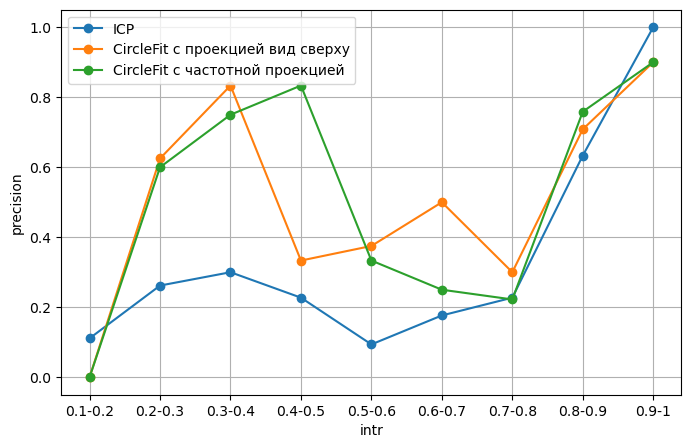

In [52]:
import matplotlib.pyplot as plt

x = range(9)
labels = ['0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1']

plt.figure(figsize=(8, 5))
plt.plot(x, precisions_icp, marker='o', label="ICP")
plt.plot(x, precisions_h, marker='o', label="CircleFit с проекцией вид сверху")
plt.plot(x, precisions_bv, marker='o', label="CircleFit с частотной проекцией")

plt.legend()
plt.xticks(x, labels)

# Оформление
plt.xlabel("intr")
plt.ylabel("precision")
plt.grid(True)
plt.show()

## График Полноты

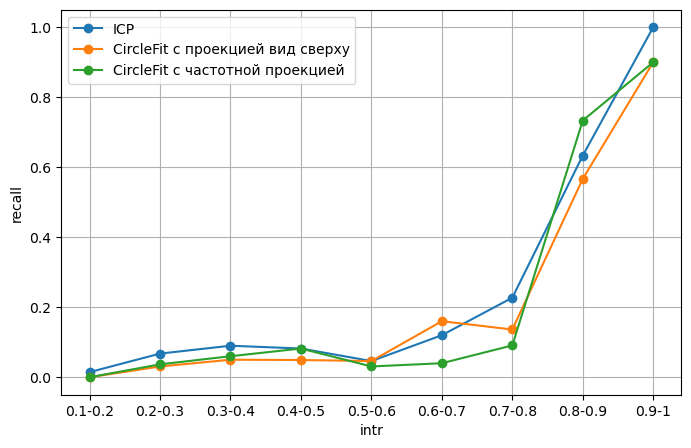

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(x, recals_icp, marker='o', label="ICP")
plt.plot(x, recals_h, marker='o', label="CircleFit с проекцией вид сверху")
plt.plot(x, recals_bv, marker='o', label="CircleFit с частотной проекцией")
plt.legend()


plt.xticks(x, labels)

# Оформление
plt.xlabel("intr")
plt.ylabel("recall")
plt.grid(True)
plt.show()

## График Среднего времени

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(x, av_times, marker='o')


plt.xticks(x, labels)

# Оформление
plt.xlabel("intr")
plt.ylabel("avarege time")
plt.grid(True)
plt.show()